# Import requre package

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import nltk,string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


# Read data

In [2]:
import re    
import nltk
def read_reviews(f,end):
    rere=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/hankchen/Desktop/semester2/660/final_project/wine bar/"+name+".csv",header=0)
        gg=data["Description"].copy()
        gg=pre_remove(gg)
        for j in gg:
            rere.append(j)
    return rere

def read_label(f,end):
    label_senti=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/hankchen/Desktop/semester2/660/final_project/wine bar/"+name+".csv",header=0)
        rr=data["label"].copy()
        for j in rr:
            label_senti.append(j)
    return label_senti

def pre_remove(reviews):
    for i in range(len(reviews)):
        #turn the text to lower case
        reviews[i]=reviews[i].lower()

        #remove emoji in the text
        RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
        reviews[i] = RE_EMOJI.sub(r'', reviews[i])
        
    return reviews

# Split data into Training data and Testing data

In [3]:
#load reviews and labels from the dataset
#we manally labelled the sentiment for the first 4 wine bar more than 1000 reviews in total 
rere=read_reviews(1,6) 
label_senti=read_label(1,6)
#set the maximum number of words and maximum length of the document
MAX_NB_WORDS=2000
MAX_DOC_LEN=150
# convert each document to a list of word index as a sequence
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(rere)
sequences = tokenizer.texts_to_sequences(rere)
padded_sequences = pad_sequences(sequences,  maxlen=MAX_DOC_LEN,padding='post', truncating='post')
#seperate date to traning and testing 
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, label_senti ,test_size=0.3, random_state=1)

# CNN Model

In [4]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model

# The dimension for embedding
EMBEDDING_DIM=100

# define input layer, where a sentence represented as
# 1 dimension array with integers
main_input = Input(shape=(MAX_DOC_LEN,),dtype='int32', name='main_input')

# define the embedding layer
embed_1 = Embedding(input_dim=MAX_NB_WORDS+1,output_dim=EMBEDDING_DIM, input_length=MAX_DOC_LEN,name='embedding')(main_input)
# define 1D convolution layer
conv1d_1= Conv1D(filters=64, kernel_size=1,name='conv_unigram',activation='relu')(embed_1)
# define a 1-dimension MaxPooling 
pool_1 = MaxPooling1D(MAX_DOC_LEN-1+1, name='pool_unigram')(conv1d_1)

flat_1 = Flatten(name='flat_unigram')(pool_1)

# filters for bigram
conv1d_2= Conv1D(filters=64, kernel_size=2, name='conv_bigram',activation='relu')(embed_1)
pool_2 = MaxPooling1D(MAX_DOC_LEN-2+1, name='pool_bigram')(conv1d_2)
flat_2 = Flatten(name='flat_bigram')(pool_2)
# filters for trigram
conv1d_3= Conv1D(filters=64, kernel_size=3, name='conv_trigram',activation='relu')(embed_1)
pool_3 = MaxPooling1D(MAX_DOC_LEN-3+1, name='pool_trigram')(conv1d_3)
flat_3 = Flatten(name='flat_trigram')(pool_3)

# Concatenate flattened output
z=Concatenate(name='concate')([flat_1, flat_2, flat_3])

# Create a dropout layer
drop_1=Dropout(rate=0.3, name='dropout')(z)

# Create a dense layer
dense_1 = Dense(192, activation='relu', name='dense')(drop_1)
# Create the output layer
preds = Dense(1, activation='sigmoid', name='output')(dense_1)

# create the model with input layer
# and the output layer
model = Model(inputs=main_input, outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 150)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 100)     200100      main_input[0][0]                 
__________________________________________________________________________________________________
conv_unigram (Conv1D)           (None, 150, 64)      6464        embedding[0][0]                  
__________________________________________________________________________________________________
conv_bigram (Conv1D)            (None, 149, 64)      12864       embedding[0][0]                  
__________________________________________________________________________________________________
conv_trigr

In [5]:
BATCH_SIZE = 64
NUM_EPOCHES = 15

# Exercise 5.4: Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model and save fitting history to "training"
training=model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES,validation_data=[X_test, y_test], verbose=2)

Train on 1312 samples, validate on 563 samples
Epoch 1/15
 - 5s - loss: 0.3981 - acc: 0.8941 - val_loss: 0.3308 - val_acc: 0.9147
Epoch 2/15
 - 3s - loss: 0.3019 - acc: 0.9116 - val_loss: 0.2856 - val_acc: 0.9147
Epoch 3/15
 - 3s - loss: 0.2623 - acc: 0.9116 - val_loss: 0.2652 - val_acc: 0.9147
Epoch 4/15
 - 3s - loss: 0.2244 - acc: 0.9116 - val_loss: 0.2464 - val_acc: 0.9147
Epoch 5/15
 - 3s - loss: 0.1764 - acc: 0.9116 - val_loss: 0.2391 - val_acc: 0.9147
Epoch 6/15
 - 3s - loss: 0.1254 - acc: 0.9253 - val_loss: 0.2325 - val_acc: 0.9183
Epoch 7/15
 - 3s - loss: 0.0943 - acc: 0.9802 - val_loss: 0.2580 - val_acc: 0.9218
Epoch 8/15
 - 3s - loss: 0.0507 - acc: 0.9870 - val_loss: 0.2661 - val_acc: 0.9183
Epoch 9/15
 - 3s - loss: 0.0266 - acc: 0.9954 - val_loss: 0.2969 - val_acc: 0.9147
Epoch 10/15
 - 3s - loss: 0.0158 - acc: 0.9985 - val_loss: 0.3455 - val_acc: 0.9201
Epoch 11/15
 - 3s - loss: 0.0096 - acc: 0.9985 - val_loss: 0.3530 - val_acc: 0.9147
Epoch 12/15
 - 3s - loss: 0.0064 - acc

       val_loss   val_acc  train_loss  train_acc
epoch                                           
0      0.330757  0.914742    0.398117   0.894055
1      0.285563  0.914742    0.301900   0.911585
2      0.265218  0.914742    0.262328   0.911585
3      0.246359  0.914742    0.224373   0.911585
4      0.239082  0.914742    0.176413   0.911585
5      0.232533  0.918295    0.125369   0.925305
6      0.257971  0.921847    0.094254   0.980183
7      0.266144  0.918295    0.050727   0.987043
8      0.296851  0.914742    0.026565   0.995427
9      0.345477  0.920071    0.015781   0.998476
10     0.353024  0.914742    0.009593   0.998476
11     0.398801  0.918295    0.006375   0.999238
12     0.425158  0.920071    0.005564   0.998476
13     0.418664  0.916519    0.004177   0.999238
14     0.432976  0.920071    0.004315   0.999238


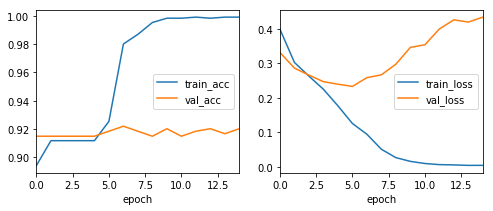

In [6]:
# get and plot training history
df=pd.DataFrame.from_dict(training.history)
df.columns=["val_loss", "val_acc", "train_loss","train_acc"]
df.index.name='epoch'
print(df)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
df[["train_acc", "val_acc"]].plot(ax=axes[0]);
df[["train_loss", "val_loss"]].plot(ax=axes[1]);
plt.show();

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


BEST_MODEL_FILEPATH="/Users/hankchen/Desktop/semester2/660/final_project/best_model"

earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

# compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

training=model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint],
          validation_data=[X_test, y_test],verbose=2)

Train on 1312 samples, validate on 563 samples
Epoch 1/15
 - 5s - loss: 0.0042 - acc: 0.9992 - val_loss: 0.5216 - val_acc: 0.9218

Epoch 00001: val_acc improved from -inf to 0.92185, saving model to /Users/hankchen/Desktop/semester2/660/final_project/best_model
Epoch 2/15
 - 3s - loss: 0.0044 - acc: 0.9985 - val_loss: 0.4482 - val_acc: 0.9183

Epoch 00002: val_acc did not improve from 0.92185
Epoch 3/15
 - 3s - loss: 0.0044 - acc: 0.9992 - val_loss: 0.4551 - val_acc: 0.9147

Epoch 00003: val_acc did not improve from 0.92185
Epoch 00003: early stopping


# Accuracy

In [8]:
# load the model using the save file
model.load_weights("/Users/hankchen/Desktop/semester2/660/final_project/best_model")
# predict
pred=model.predict(X_test)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

lala=np.where(pred>0.9,1,0)
print(classification_report(y_test, lala, target_names=['0','1']))
pd.crosstab(pd.Series(y_test), pd.Series(lala[:,0]))

acc: 92.18%
              precision    recall  f1-score   support

           0       0.42      0.35      0.39        48
           1       0.94      0.96      0.95       515

   micro avg       0.90      0.90      0.90       563
   macro avg       0.68      0.65      0.67       563
weighted avg       0.90      0.90      0.90       563



col_0,0,1
row_0,,
0,17,31
1,23,492


0.8421116504854368


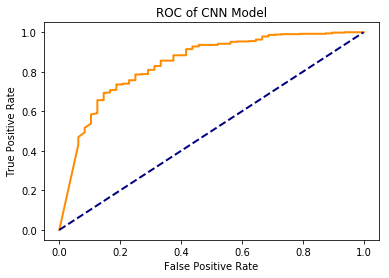

In [9]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
#calculate AUC
fpr, tpr, thresholds = roc_curve(y_test, pred,pos_label=1)
print(auc(fpr, tpr))
#plot ROC curve
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC of CNN Model');
plt.show();

In [10]:
#To predict the sentiment for a certain wine bar 
pp=read_reviews(16,17)   
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(pp)
sequences = tokenizer.texts_to_sequences(pp)
padded_sequences2 = pad_sequences(sequences,  maxlen=MAX_DOC_LEN,padding='post', truncating='post')
predicted3=model.predict(padded_sequences2)

In [11]:
# topic extraction using CNN
data=pd.read_csv("/Users/hankchen/Desktop/semester2/660/final_project/660 final/Trainning_mutilabeled.csv",header=0)

text=list(data["Description"].copy())
text=pre_remove(text)
labels=data[["Food","Service","Atmosphere","Price"]].copy().values 

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(text)
voc=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text)
padded_sequences = pad_sequences(sequences,maxlen=150,padding='post', truncating='post')

In [12]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
              
def cnn_model(FILTER_SIZES, \
              # filter sizes as a list
              MAX_NB_WORDS, \
              # total number of words
              MAX_DOC_LEN, \
              # max words in a doc
              EMBEDDING_DIM=100, \
              # word vector dimension
              NUM_FILTERS=64, \
              # number of filters for all size
              DROP_OUT=0.3, \
              # dropout rate
              NUM_OUTPUT_UNITS=1, \
              # number of output units
              NUM_DENSE_UNITS=100,\
              # number of units in dense layer
              PRETRAINED_WORD_VECTOR=None,\
              # Whether to use pretrained word vectors
              LAM=0.0):            
              # regularization coefficient
    
    main_input = Input(shape=(MAX_DOC_LEN,), \
                       dtype='int32', name='main_input')
    
    if PRETRAINED_WORD_VECTOR is not None:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        # use pretrained word vectors
                        weights=[PRETRAINED_WORD_VECTOR],\
                        # word vectors can be further tuned
                        # set it to False if use static word vectors
                        trainable=True,\
                        name='embedding')(main_input)
    else:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        name='embedding')(main_input)
    # add convolution-pooling-flat block
    conv_blocks = []
    for f in FILTER_SIZES:
        conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                      activation='relu', name='conv_'+str(f))(embed_1)
        conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
        conv = Flatten(name='flat_'+str(f))(conv)
        conv_blocks.append(conv)
    
    if len(conv_blocks)>1:
        z=Concatenate(name='concate')(conv_blocks)
    else:
        z=conv_blocks[0]
        
    drop=Dropout(rate=DROP_OUT, name='dropout')(z)

    dense = Dense(NUM_DENSE_UNITS, activation='relu',\
                    kernel_regularizer=l2(LAM),name='dense')(drop)
    preds = Dense(NUM_OUTPUT_UNITS, activation='sigmoid', name='output')(dense)
    model = Model(inputs=main_input, outputs=preds)
    
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", metrics=["accuracy"]) 
    
    return model

In [13]:
EMBEDDING_DIM=100
FILTER_SIZES=[1,2,3,4]

# as the number of classes
num_filters=64
# set the dense units
dense_units_num= num_filters*len(FILTER_SIZES)

BTACH_SIZE = 64
NUM_EPOCHES = 20

X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, labels ,test_size=0.3, random_state=1)
model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, MAX_DOC_LEN, NUM_FILTERS=num_filters,NUM_OUTPUT_UNITS=4, NUM_DENSE_UNITS=dense_units_num)


earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss',verbose=2, save_best_only=True, mode='min')

training=model.fit(X_train, Y_train, batch_size=64, epochs=10,callbacks=[earlyStopping, checkpoint], validation_data=[X_test, Y_test], verbose=2)


Train on 494 samples, validate on 212 samples
Epoch 1/10
 - 5s - loss: 0.6407 - acc: 0.6837 - val_loss: 0.5787 - val_acc: 0.7311

Epoch 00001: val_loss improved from inf to 0.57866, saving model to /Users/hankchen/Desktop/semester2/660/final_project/best_model
Epoch 2/10
 - 2s - loss: 0.5715 - acc: 0.7227 - val_loss: 0.5533 - val_acc: 0.7311

Epoch 00002: val_loss improved from 0.57866 to 0.55333, saving model to /Users/hankchen/Desktop/semester2/660/final_project/best_model
Epoch 3/10
 - 2s - loss: 0.5546 - acc: 0.7227 - val_loss: 0.5299 - val_acc: 0.7323

Epoch 00003: val_loss improved from 0.55333 to 0.52994, saving model to /Users/hankchen/Desktop/semester2/660/final_project/best_model
Epoch 4/10
 - 2s - loss: 0.5212 - acc: 0.7621 - val_loss: 0.5007 - val_acc: 0.7901

Epoch 00004: val_loss improved from 0.52994 to 0.50075, saving model to /Users/hankchen/Desktop/semester2/660/final_project/best_model
Epoch 5/10
 - 2s - loss: 0.4762 - acc: 0.7935 - val_loss: 0.4555 - val_acc: 0.8090

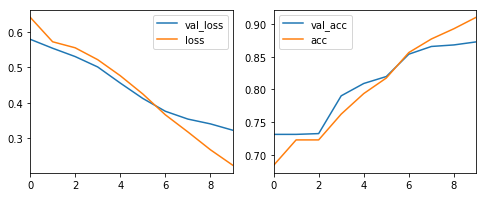

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

        Food       0.88      0.91      0.90       149
     Service       0.96      0.84      0.89        85
  Atmosphere       0.65      0.73      0.68        55
       Price       0.24      0.72      0.36        25

   micro avg       0.73      0.84      0.78       314
   macro avg       0.68      0.80      0.71       314
weighted avg       0.81      0.84      0.82       314
 samples avg       0.63      0.68      0.64       314

col_0   0    1
row_0         
0.0    45   13
1.0    18  136
col_0    0   1
row_0         
0.0    124  14
1.0      3  71
col_0    0   1
row_0         
0.0    135  15
1.0     22  40
col_0    0   1
row_0         
0.0    130   7
1.0     57  18


In [14]:
from sklearn.metrics import classification_report

#traning history
df=pd.DataFrame.from_dict(training.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
df[["val_loss", "loss"]].plot(ax=axes[0]);
df[["val_acc", "acc"]].plot(ax=axes[1]);
plt.show();
#predict and classify the output using different theshold
pred=model.predict(X_test)
pred[:,0]=np.where(pred[:,0]>0.5, 1, 0)
pred[:,1]=np.where(pred[:,1]>0.5, 1, 0)
pred[:,2]=np.where(pred[:,2]>0.28, 1, 0)
pred[:,3]=np.where(pred[:,3]>0.17, 1, 0)
#see the performance of this model
print(classification_report(Y_test, pred,target_names=['Food','Service','Atmosphere','Price']))
#confusion matrix
print(pd.crosstab(pred[:,0],Y_test[:,0]))
print(pd.crosstab(pred[:,1],Y_test[:,1]))
print(pd.crosstab(pred[:,2],Y_test[:,2]))
print(pd.crosstab(pred[:,3],Y_test[:,3]))


In [15]:
#To predict the topic for a certain wine bar
#let's take a 8th bar in our data as an example
#pp=read_reviews(14,15)   
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(pp)
sequences = tokenizer.texts_to_sequences(pp)
padded_sequences3 = pad_sequences(sequences,  maxlen=MAX_DOC_LEN,padding='post', truncating='post')
predicted4=model.predict(padded_sequences3)

In [16]:
#Result interpret
#topic result classify
predicted4[:,0]=np.where(predicted4[:,0]>0.5, 1, 0)
predicted4[:,1]=np.where(predicted4[:,1]>0.5, 1, 0)
predicted4[:,2]=np.where(predicted4[:,2]>0.28, 1, 0)
predicted4[:,3]=np.where(predicted4[:,3]>0.17, 1, 0)
predictions2=pd.DataFrame(predicted4,columns=["Foodp","Servicep","Atmospherep","Pricep"])
#sentiment result classify
predicted3=np.where(predicted3>0.9,1,0)

Food=pd.crosstab(predictions2["Foodp"],predicted3[:,0]).iloc[1,:]
Service=pd.crosstab(predictions2["Servicep"],predicted3[:,0]).iloc[1,:]
Atmosphere=pd.crosstab(predictions2["Atmospherep"],predicted3[:,0]).iloc[1,:]
Price=pd.crosstab(predictions2["Pricep"],predicted3[:,0]).iloc[1,:]
result=pd.DataFrame(dict(Food=Food, Service=Service,Atmosphere=Atmosphere,Price=Price))
print("total reviews:",len(pp))
print("Food:",result.iloc[0,0]/(result.iloc[0,0]+result.iloc[1,0]))
print("Service:",result.iloc[0,1]/(result.iloc[0,1]+result.iloc[1,1]))
print("Atmosphere:",result.iloc[0,2]/(result.iloc[0,2]+result.iloc[1,2]))
print("Price:",result.iloc[0,3]/(result.iloc[0,3]+result.iloc[1,3]))
result

total reviews: 178
Food: 0.07079646017699115
Service: 0.1206896551724138
Atmosphere: 0.05454545454545454
Price: 0.20833333333333334


,Food,Service,Atmosphere,Price
col_0,,,,
0,8,7,3,10
1,105,51,52,38
